# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv('/datasets/Churn.csv', index_col=0)

In [3]:
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [5]:
#проверим наличие десятичных дробей с числом, отличным от нуля после точки
print('Количество дробных чисел в столбце "Tenure":' ,((data[~data['Tenure'].isna()]['Tenure'] % data[~data['Tenure'].isna()]['Tenure'].astype('int')) > 0).sum())

Количество дробных чисел в столбце "Tenure": 0


In [6]:
data[~data['Tenure'].isna()] 

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15719294,Wood,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0


In [7]:
#посмотрим на количество столбцов в инверсии
data.isna().sum()

CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [8]:
print('Количество полных дубликатов в дата-сете:', data.duplicated().sum())
print('Количество уникальных значений в столбце "CustomerId":', len(data['CustomerId'].unique()))

Количество полных дубликатов в дата-сете: 0
Количество уникальных значений в столбце "CustomerId": 10000


Оценим данные на предмет нерелевантных значений.

In [9]:
data['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [10]:
data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [11]:
data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Наблюдаем следующее:
1. В таблице нет полностью дублированных строк
2. Все идентификаторы пользователей в таблице уникальны
3. Из 13 столбцов в таблице пропуски наблюдаются только в `Tenure` (количество лет, в течение которых данный человек являлся клиентом банка) - пропущено 909 значений. Вероятно, потребуется заполнение этого столбца - исходим из допущения о том, что продолжительность использования услуг банка имеет связь с его актуальным статусом
4. В столбце `Tenure` потребуется преобразование данных из числа с плавающей точкой в целое число
5. Вероятно, столбцы `Balance` и `EstimatedSalary` также будет иметь смысл преобразовать в целое число, так как количество копеек не представляется данными, формирующими дополнительную аналитическую ценность при решении поставленной задачи
6. В остальном, явные аномалии в данных не наблюдаются

### Предобработка данных

Перед преобразованием типов заполним пропуски в данных. Нам необходимо выработать принцип, в соответствии с которым будет произведено заполнение пропусков в столбце. Предположительно, наибольшая связь должна наблюдаться между продолжительностью использования услуг банка и возрастом клиента (столбце `Age`). Однако также может иметь значение и страна, так как, например, данный банк мог быть запущен в разных странах с разным лагом. Воспользуем инструментарием для поиска линейной зависимости - матрицей корреляции. 

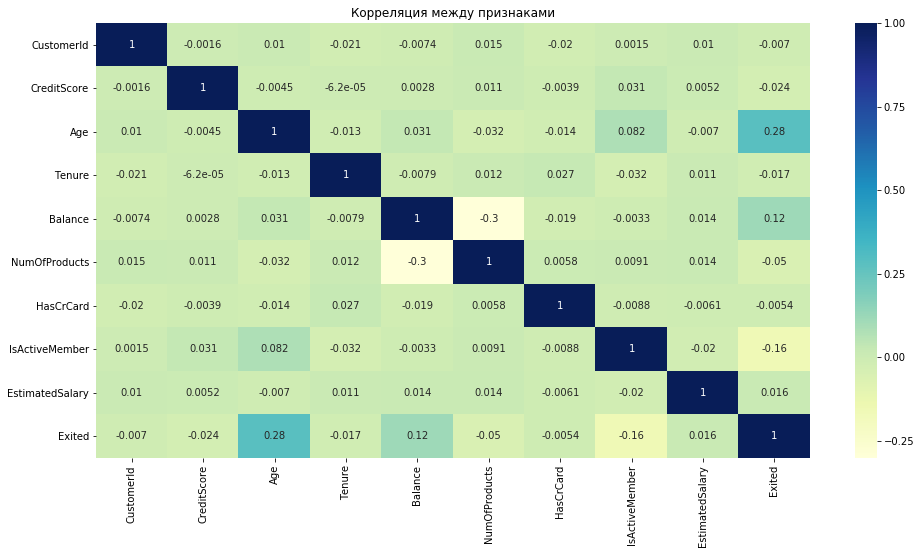

In [12]:
plt.figure(figsize=[16,8])
plt.title('Корреляция между признаками')
dataplot = sns.heatmap(data[~data['Tenure'].isna()].corr(), cmap="YlGnBu", annot=True)

plt.show()

Мы наблюдаем отсутствие значимых линейных зависимостей между признаками в принципе. Гипотеза о зависимости возраста и продолжительности использования клиентом услуг банка не подтверждается, поэтому можем положиться на заполнения недостающих значений медианными значениями. Для снижения количества однообразных значений, возьмем медиану для групп по возрасту и стране использования. 

In [13]:
#соберем датафрейм с референтными значениями
median_tenure = data[~data['Tenure'].isna()].groupby(['Geography', 'Age'], as_index=False).agg({'Tenure': 'median'})
median_tenure

,Geography,Age,Tenure
0,France,18,6.0
1,France,19,5.0
2,France,20,4.0
3,France,21,4.0
4,France,22,5.0
...,...,...,...
191,Spain,77,5.0
192,Spain,78,2.0
193,Spain,79,5.0
194,Spain,80,8.0


In [14]:
#формируем новый столбец с референтными значениями, полученными на первом шаге

data = data.merge(
    median_tenure,
    on=['Geography', 'Age'],
    how='left')

#при помощи логической индексации записываем референтные значения только для тех объектов, у которых ранее были пропуски
data.loc[data['Tenure_x'].isna(), 'Tenure_x'] = data['Tenure_y']

#выбрасываем столбец с референтными значениями, так как он нам более не требуется и обратно меняем наименование исходного столбца
data = data.drop('Tenure_y', axis=1)
data = data.rename(columns={'Tenure_x': 'Tenure'})

In [15]:
print('Количество пропусков в столбце "Tenure":', data['Tenure'].isna().sum())

Количество пропусков в столбце "Tenure": 0


Больше пропусков в столбце `Tenure` не наблюдается. Перейдем к преобразованию типов. 

In [16]:
data['Tenure'] = data['Tenure'].astype('int') 
data['Balance'] = data['Balance'].astype('int') 
data['EstimatedSalary'] = data['EstimatedSalary'].astype('int') 

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null int64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null int64
Exited             10000 non-null int64
dtypes: int64(10), object(3)
memory usage: 1.1+ MB


1. Пропуски в столбце `Tenure` заполнены референтными значениями
2. Преобразованы типы данных в столбцах `Tenure`, `Balance`, `EstimatedSalary`

### Подготовка данных для обучения

Целевым признаком в настоящей задаче является содержимое столбца `Exited`. Этот столбец содержит только нули и единицы, что с учетом постановки исходной задачи говорит нам о необходимости решения задачи бинарной классификации. 

Перед переходом к решению задачи проведем следующие процедуры:

. Деление датафрейма на признаки и целевой признак
. Деление двух полученных датафреймов на обучающую, валидационную и тестовую выборки
. Кодирование переменных
. Масштабирование признаков 

In [18]:
#формируем датафреймы с признаками и целевым признаком
features = data.drop(['CustomerId', 'Surname', 'Exited'], axis=1)
target = data['Exited']

Помимо целевого признака из датафрейма стоит удалить столбцы `CustomerId` и `Surname`, так как они содержат персонализированную информацию, которая нам не требуется при анализе признаков обезличенных сущностей (клиенты) - маловероятно, что ID пользователя или его фамилия как-то связаны с вероятностью ухода пользователя из банка (разве что в банке есть дискриминация по фамилии).

In [19]:
#разобъем исходные данные на три выборки при помощи функции
def three_samples_split(features, target, train_sample_size=0.60, validation_sample_size=0.20):
    from sklearn.model_selection import train_test_split
    initial_data_lenght = len(target)
    train_features, df_features, train_target, df_target = train_test_split(
        features,
        target,
        train_size=train_sample_size,
        random_state=12345
    )
    current_validation_sample_size = (initial_data_lenght * validation_sample_size) / len(df_target)
    validation_features, test_features, validation_target, test_target = train_test_split(
        df_features,
        df_target,
        train_size=current_validation_sample_size,
        random_state=12345
    )
    return train_features, train_target, validation_features, validation_target, test_features, test_target

In [20]:
train_features, train_target, validation_features, validation_target, test_features, test_target = three_samples_split(features, target)

In [21]:
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(6000, 10)
(2000, 10)
(2000, 10)


Для обучения модели нам потребуется выполнить кодирование переменных. Так как мы исключили фамилию и идентификатор клиента из сета, из категориальных переменных у нас осталась только страна проживания и пол. Для кодирования таких переменной в наилучшей степени подойдет прямое кодирование, так как значения не являются ранговыми (мы не можем расположить одно над другим в каком-то порядке). 

In [22]:
train_features = pd.get_dummies(train_features, drop_first=True)
validation_features = pd.get_dummies(validation_features, drop_first=True)
test_features = pd.get_dummies(test_features, drop_first=True)

In [23]:
train_features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,567,35,8,153137,1,1,0,88659,0,1,1
3411,711,37,8,113899,1,0,0,80215,0,0,0
6027,850,44,3,140393,2,0,1,186285,1,0,1
1247,512,24,6,0,2,1,0,37654,0,0,1
3716,665,27,2,147435,1,0,0,187508,1,0,0


Выполним масштабирование признаков.

In [24]:
#положим в переменную список наименование столбцов в которых у нас лежат количественные переменные
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [25]:
#положим в переменную объект Scaler
scaler = StandardScaler()

#выполним обучение скейлера и преобразование количественных переменных на выборках
train_features[numeric] = scaler.fit_transform(train_features[numeric])
validation_features[numeric] = scaler.transform(validation_features[numeric])
test_features[numeric] = scaler.transform(test_features[numeric])

## Исследование задачи

### Логистическая регрессия

Мы располагаем очищенными данными, которые мы разделили на три выборки, выполнили кодирование переменных и масштабирование количественных признаков. Далее мы можем выполнить обучение моделей с использованием нескольких алгоритмов для выбора наилучшего по целевой метрике. 

In [26]:
model = LogisticRegression(random_state=12345, solver='lbfgs')
model = model.fit(train_features, train_target)
result_validation = model.score(validation_features, validation_target)
result_test = model.score(test_features, test_target)

In [27]:
predictions = model.predict(validation_features)

In [28]:
precision = precision_score(validation_target, predictions)
recall = recall_score(validation_target, predictions)
f1 = f1_score(validation_target, predictions)

print(f'Полнота: {recall:.1%}')
print(f'Точность: {precision:.1%}')
print(f'F1-мера: {f1:.1%}')

Полнота: 23.4%
Точность: 56.6%
F1-мера: 33.2%


Логистическая регрессия не дает приемлемых результатов. Судя по метрике Recall, модель слишком часто относит объект положительного класса к негативным объектам. 

### Дерево решений

В качестве следующего алгоритма воспользуемся деревом решений. При помощи перебора гиперпараметров попробуем выбрать наилучшую их конфигурация для этого алгоритма с целью получить наивысшее значение меры F1 до балансировки классов или управления попрогом. 

In [29]:
model = DecisionTreeClassifier(random_state=12345)

#при помощи кросс-валидации переберем параметры дерева решений
gscv = GridSearchCV(
    model,
    {
        'max_depth': [x for x in range(train_features.shape[1], 21)],
        'criterion': ['gini', 'entropy']
    },
    cv=5,
    return_train_score=False,
    scoring = 'f1'
)

gscv.fit(train_features, train_target)
report = pd.DataFrame(gscv.cv_results_)
report = report[['param_criterion', 'param_max_depth', 'mean_test_score', 'mean_fit_time']]
report.sort_values(by='mean_test_score', ascending=False).head(10)

,param_criterion,param_max_depth,mean_test_score,mean_fit_time
0,gini,11,0.538034,0.017797
10,entropy,11,0.535185,0.021243
11,entropy,12,0.533336,0.022054
12,entropy,13,0.529184,0.022146
13,entropy,14,0.525602,0.022984
1,gini,12,0.525336,0.017884
14,entropy,15,0.521749,0.023329
2,gini,13,0.521729,0.018982
15,entropy,16,0.521546,0.023910
4,gini,15,0.518054,0.019937


In [30]:
#обучим дерево решений с наилучшими гиперпараметрами и сформируем предсказания на валидационной выборке
model = DecisionTreeClassifier(max_depth=11, random_state=12345)
model = model.fit(train_features, train_target)

predictions = model.predict(validation_features)

In [31]:
precision = precision_score(validation_target, predictions)
recall = recall_score(validation_target, predictions)
f1 = f1_score(validation_target, predictions)

print(f'Полнота: {recall:.1%}')
print(f'Точность: {precision:.1%}')
print(f'F1-мера: {f1:.1%}')

Полнота: 47.6%
Точность: 58.4%
F1-мера: 52.4%


Мы видим, что на кросс-валидации параметры показали чуть лучший результат (в пределах погрешности - 1.4 процентных пункта). Однако мы наблюдаем значительный рост качества модели (с 33% до 52.4%) в первую очередь за счет снижения количества ошибок первого рода (рост метрики recall). Тем не менее, эта модель не дает нам небходимого качества (59%), что вынуждает нас продолжить исследование.  

### Случайный лес

In [32]:
model = RandomForestClassifier(random_state=12345)

#при помощи кросс-валидации переберем параметры дерева решений
gscv = GridSearchCV(
    model,
    {
        'max_depth': [x for x in range(train_features.shape[1], train_features.shape[1]*2, 2)],
        'n_estimators': [x for x in range(50, 160, 10)]
    },
    cv=5,
    return_train_score=False,
    scoring = 'f1'
)

gscv.fit(train_features, train_target)
report = pd.DataFrame(gscv.cv_results_)
report = report[['param_n_estimators', 'param_max_depth', 'mean_test_score', 'mean_fit_time']]
report.sort_values(by='mean_test_score', ascending=False).head(10)

,param_n_estimators,param_max_depth,mean_test_score,mean_fit_time
36,80,17,0.579202,0.411915
37,90,17,0.579094,0.455972
39,110,17,0.578605,0.506133
40,120,17,0.577975,0.582134
41,130,17,0.576620,0.624702
38,100,17,0.576075,0.502191
35,70,17,0.575716,0.343139
64,140,21,0.574674,0.663318
65,150,21,0.574507,0.718507
42,140,17,0.574253,0.671828


Наблюдаем схожее значение метрики F1 для всех комбинаций гиперпараметров в топе отчета.

In [33]:
#обучим дерево решений с наилучшими гиперпараметрами и сформируем предсказания на валидационной выборке
model = RandomForestClassifier(max_depth=17, n_estimators=80, random_state=12345)
model = model.fit(train_features, train_target)

predictions = model.predict(validation_features)

In [34]:
precision = precision_score(validation_target, predictions)
recall = recall_score(validation_target, predictions)
f1 = f1_score(validation_target, predictions)

print(f'Полнота: {recall:.1%}')
print(f'Точность: {precision:.1%}')
print(f'F1-мера: {f1:.1%}')

Полнота: 45.9%
Точность: 76.2%
F1-мера: 57.3%


Наблюдаем рост метрики F1 примерно на 5 процентных пунктов - в большей степени это произошло за счет метрики precision, то есть снижения количества объектов негативного класса, классифицированных как объекты положительного класса (ошибки второго рода). 

## Борьба с дисбалансом

Попробуем отбалансировать классы внутри обучающей выборки. Для этого воспользуемся двумя способами:

1. Обогащение тренировочной выборки объектами положительного класса - апсемплинг
2. Управление порогом классификации

In [35]:
#оценим баланс классов в обучающей выборке
train_target.value_counts(normalize=True)

0    0.800667
1    0.199333
Name: Exited, dtype: float64

### Апсемплинг

In [36]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [37]:
features_upsampled, target_upsampled = upsample(train_features, train_target, 4)

In [38]:
#посмотрим, как теперь выглядит баланс классов в обогащенной выборке
target_upsampled.value_counts(normalize=True)

0    0.501043
1    0.498957
Name: Exited, dtype: float64

#### Логистическая регрессия

Повторим обучение логистической регрессии, но уже на обогащенных данных. После обучения также повторим предсказание и оценим изменение точности прогнозирования. 

In [39]:
#обучим дерево решений с наилучшими гиперпараметрами и сформируем предсказания на валидационной выборке
model = LogisticRegression(random_state=12345, solver='lbfgs')
model = model.fit(features_upsampled, target_upsampled)

predictions = model.predict(validation_features)

In [40]:
precision = precision_score(validation_target, predictions)
recall = recall_score(validation_target, predictions)
f1 = f1_score(validation_target, predictions)

print(f'Полнота: {recall:.1%}')
print(f'Точность: {precision:.1%}')
print(f'F1-мера: {f1:.1%}')

Полнота: 68.2%
Точность: 38.1%
F1-мера: 48.8%


In [41]:
probabilities_valid = model.predict_proba(validation_features)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(validation_target, probabilities_one_valid)

auc_roc = roc_auc_score(y_true=validation_target, y_score=probabilities_one_valid)

print(f'AUC-ROC: {auc_roc:.1%}')

AUC-ROC: 76.4%


#### Дерево решений

In [42]:
#обучим дерево решений с наилучшими гиперпараметрами и сформируем предсказания на валидационной выборке
model = DecisionTreeClassifier(max_depth=11, random_state=12345)
model = model.fit(features_upsampled, target_upsampled)

predictions = model.predict(validation_features)

In [43]:
precision = precision_score(validation_target, predictions)
recall = recall_score(validation_target, predictions)
f1 = f1_score(validation_target, predictions)

print(f'Полнота: {recall:.1%}')
print(f'Точность: {precision:.1%}')
print(f'F1-мера: {f1:.1%}')

Полнота: 61.2%
Точность: 46.6%
F1-мера: 52.9%


In [44]:
probabilities_valid = model.predict_proba(validation_features)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(validation_target, probabilities_one_valid)

auc_roc = roc_auc_score(y_true=validation_target, y_score=probabilities_one_valid)

print(f'AUC-ROC: {auc_roc:.1%}')

AUC-ROC: 74.3%


#### Случайный лес

In [45]:
#обучим дерево решений с наилучшими гиперпараметрами и сформируем предсказания на валидационной выборке
model = RandomForestClassifier(max_depth=17, n_estimators=80, random_state=12345)
model = model.fit(features_upsampled, target_upsampled)

predictions = model.predict(validation_features)

In [46]:
precision = precision_score(validation_target, predictions)
recall = recall_score(validation_target, predictions)
f1 = f1_score(validation_target, predictions)

print(f'Полнота: {recall:.1%}')
print(f'Точность: {precision:.1%}')
print(f'F1-мера: {f1:.1%}')

Полнота: 56.9%
Точность: 66.3%
F1-мера: 61.3%


In [47]:
predictions = model.predict(test_features)

In [48]:
precision = precision_score(test_target, predictions)
recall = recall_score(test_target, predictions)
f1 = f1_score(test_target, predictions)

print(f'Полнота: {recall:.1%}')
print(f'Точность: {precision:.1%}')
print(f'F1-мера: {f1:.1%}')

Полнота: 55.3%
Точность: 64.6%
F1-мера: 59.6%


In [49]:
probabilities_valid = model.predict_proba(validation_features)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(validation_target, probabilities_one_valid)

auc_roc = roc_auc_score(y_true=validation_target, y_score=probabilities_one_valid)

print(f'AUC-ROC: {auc_roc:.1%}')

AUC-ROC: 84.4%


### Изменение порога классификации

Теперь попробуем использовать выборки без апскейлинга, но применим измененные пороги классификации. Поставим эксперимент с алгоритмом, который дал наилучший результат на предыдущих шагах - случайный лес. 

In [50]:
model = RandomForestClassifier(max_depth=17, n_estimators=80, random_state=12345)
model = model.fit(train_features, train_target)

predictions = model.predict(validation_features)

In [51]:
probabilities_valid = model.predict_proba(validation_features)
probabilities_one_valid = probabilities_valid[:, 1]

In [52]:
for threshold in np.arange(0, 0.5, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(validation_target, predicted_valid)
    recall = recall_score(validation_target, predicted_valid)
    f1 = f1_score(validation_target, predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.214, Полнота = 0.995, F1-мера = 0.352
Порог = 0.01 | Точность = 0.222, Полнота = 0.983, F1-мера = 0.362
Порог = 0.02 | Точность = 0.237, Полнота = 0.967, F1-мера = 0.380
Порог = 0.03 | Точность = 0.251, Полнота = 0.964, F1-мера = 0.398
Порог = 0.04 | Точность = 0.260, Полнота = 0.947, F1-мера = 0.408
Порог = 0.05 | Точность = 0.270, Полнота = 0.935, F1-мера = 0.419
Порог = 0.06 | Точность = 0.282, Полнота = 0.926, F1-мера = 0.432
Порог = 0.07 | Точность = 0.296, Полнота = 0.911, F1-мера = 0.447
Порог = 0.08 | Точность = 0.307, Полнота = 0.900, F1-мера = 0.458
Порог = 0.09 | Точность = 0.320, Полнота = 0.895, F1-мера = 0.472
Порог = 0.10 | Точность = 0.332, Полнота = 0.880, F1-мера = 0.482
Порог = 0.11 | Точность = 0.342, Полнота = 0.864, F1-мера = 0.489
Порог = 0.12 | Точность = 0.357, Полнота = 0.854, F1-мера = 0.504
Порог = 0.13 | Точность = 0.374, Полнота = 0.849, F1-мера = 0.519
Порог = 0.14 | Точность = 0.382, Полнота = 0.830, F1-мера = 0.523
Порог = 0.

Мы наблюдаем, что для порога вероятности в 39%, мы получаем наилучшее значение F-меры. Оно даже лучше, чем наилучшее значение, полученное тем же алгоритмов с такими же гиперпараметрами на выборке, подвергшейся апсемлингу. Проведем тестирование в соответствующем разделе.

## Тестирование модели

Повторно обучим модель и построим для нее ROC-кривые: для дефолтного и кастомизированного порогов классификации. По итогам, сможем установить, какой из вариантов в наилучшей степени подходит для решения поставленной задачи. 

In [53]:
model = RandomForestClassifier(max_depth=17, n_estimators=80, random_state=12345)
model = model.fit(features_upsampled, target_upsampled)

In [54]:
predictions = model.predict(test_features)

In [55]:
precision = precision_score(test_target, predictions)
recall = recall_score(test_target, predictions)
f1 = f1_score(test_target, predictions)

print(f'Полнота: {recall:.1%}')
print(f'Точность: {precision:.1%}')
print(f'F1-мера: {f1:.1%}')

Полнота: 55.3%
Точность: 64.6%
F1-мера: 59.6%


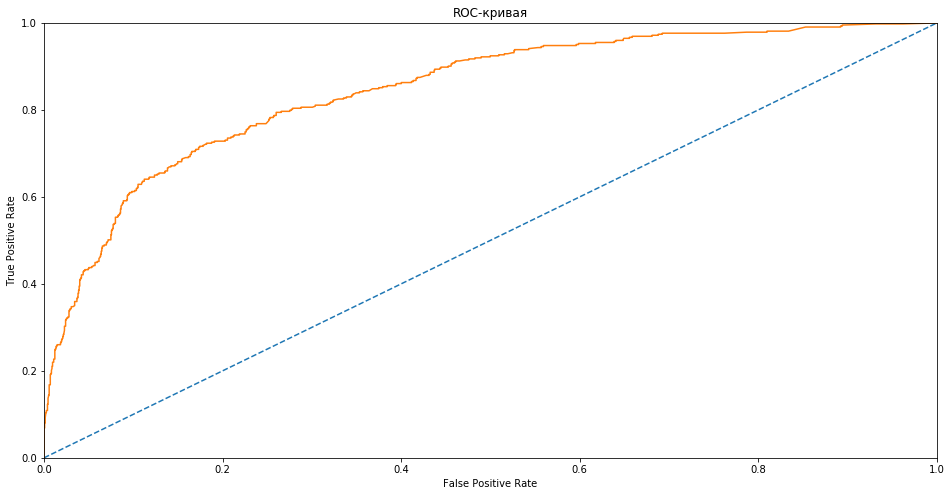

In [56]:
probabilities_valid = model.predict_proba(test_features)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(test_target, probabilities_one_valid)

plt.figure(figsize=(16, 8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

In [57]:
auc_roc = roc_auc_score(y_true=test_target, y_score=probabilities_one_valid)

print(f'AUC-ROC: {auc_roc:.1%}')

AUC-ROC: 84.6%


In [58]:
probabilities_valid = model.predict_proba(test_features)
probabilities_one_valid = probabilities_valid[:, 1]

In [59]:
threshold = 0.39
predicted_valid = probabilities_one_valid > threshold 
precision = precision_score(test_target, predicted_valid)
recall = recall_score(test_target, predicted_valid)
f1 = f1_score(test_target, predicted_valid)

print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}".format(threshold, precision, recall, f1))

Порог = 0.39 | Точность = 0.576, Полнота = 0.655, F1-мера = 0.613


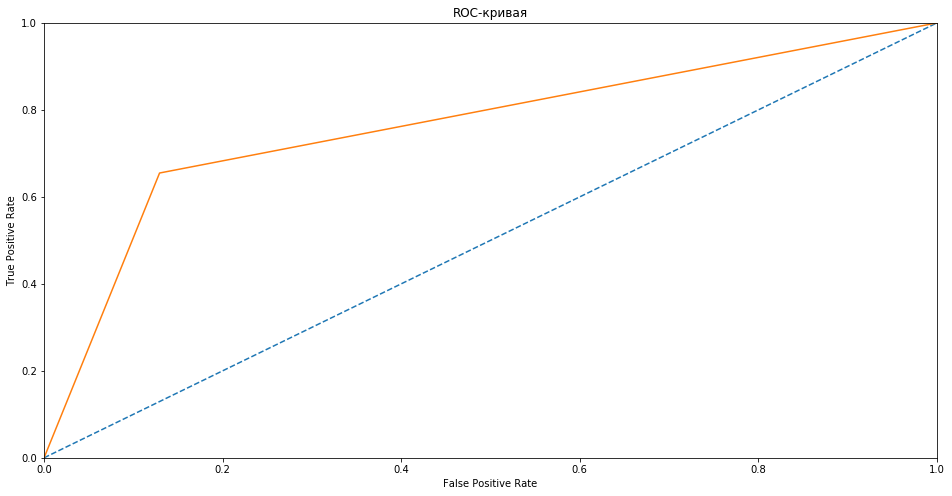

In [60]:
fpr, tpr, thresholds = roc_curve(test_target, predicted_valid)

plt.figure(figsize=(16, 8))

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

In [61]:
auc_roc = roc_auc_score(y_true=test_target, y_score=predicted_valid)

print(f'AUC-ROC: {auc_roc:.1%}')

AUC-ROC: 76.3%


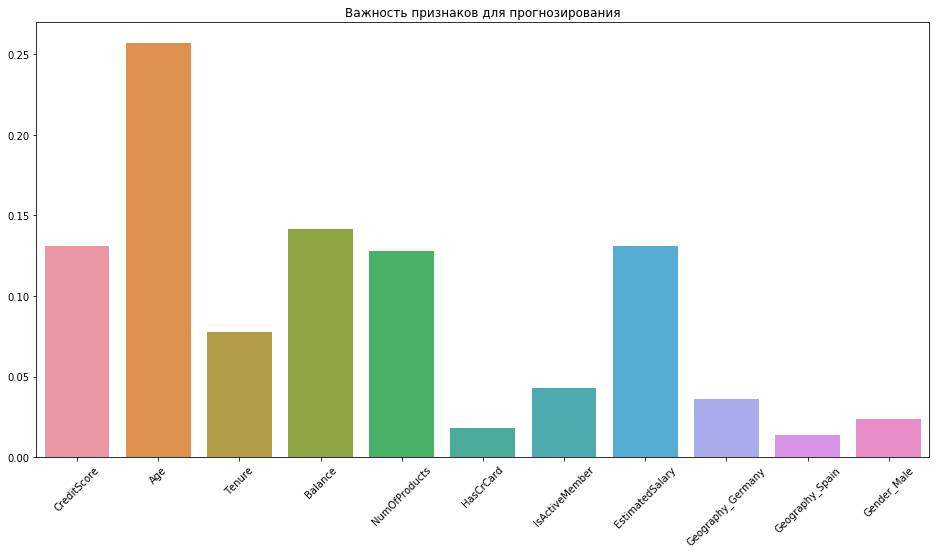

In [67]:
plt.figure(figsize=(16, 8))
plt.title('Важность признаков для прогнозирования')
plt.xticks(rotation=45)
sns.barplot(y=model.feature_importances_, x=features_upsampled.columns)

Наблюдаем следующее:

1. При дефолтном и кастомном порогах классификации модель позволяет получить целевое значение F-меры в 59%
2. При использовании фиксированного порога классификации мы наблюдаем "рубленую" форму ROC-кривой, что вероятно объясняется "искуственной" природой порога
3. Использование стандартного порога классификации возвращает лучшее значение AUC-ROC (+8 процентных пунктов), что позволяет утверждать нам о более точной способности модели классифицировать объекты и точно предсказывать отток клиента из банка

## Выводы

1. Произведено исследование данных - наблюдался явный дисбаланс классов (20% выборки - целевой класс) - для повышения точности использован метод апсемлинга, а также перебор порогов классификации: установлено, что апсемлинг позволяет получить желаемый результат
2. В качестве алгоритмов для модели использованы три варианта со следующими значениями F1-меры на апсемленных данных:
+ Логистическая регрессия (F1 ~49%)
+ Дерево решений (F1 ~53%)
+ (F1 ~61% для валидационной выборки и 60% для тестовой)
3. Целевое значение достигнуто моделью, постороенной на базе алгоритма RandomForest со следующими гиперпараметрами:
+ Количество деревьев - 80
+ Глубина дерева - 17 
4. Метрика AUC-ROC для указанного алгоритма на тестовой выборке показывает значение ~84%, что говорит о неплохой способности модели корректно предсказывать целевой признак объекта